In [1]:
import torch 
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import  TensorDataset, Dataset, DataLoader

from tqdm.notebook import tqdm
import numpy as np

In [2]:
from aijack.defense import VIB, KL_between_normals, mib_loss

In [3]:
dim_z = 256
beta = 1e-3
batch_size = 100
samples_amount = 15
num_epochs = 1

In [4]:
train_data = MNIST('MNIST/.', download=True, train=True)
train_dataset = TensorDataset(train_data.train_data.view(-1, 28 * 28).float() / 255, train_data.train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_data = MNIST('MNIST/.', download=True, train=False)
test_dataset = TensorDataset(test_data.test_data.view(-1, 28 * 28).float() / 255, test_data.test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Files already downloaded
Files already downloaded


In [5]:
encoder = nn.Sequential(nn.Linear(in_features=784, out_features=1024),
                                     nn.ReLU(),
                                     nn.Linear(in_features=1024, out_features=1024),
                                     nn.ReLU(),
                                     nn.Linear(in_features=1024, out_features=2 * dim_z))
decoder = nn.Linear(in_features=dim_z, out_features=10)

In [6]:
net =  VIB(encoder, decoder, dim_z, num_samples=samples_amount)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.97)

In [7]:
import time

for epoch in range(num_epochs):
    loss_by_epoch = []
    accuracy_by_epoch = []
    I_ZX_bound_by_epoch = []
    I_ZY_bound_by_epoch = []
    
    loss_by_epoch_test = []
    accuracy_by_epoch_test = []
    I_ZX_bound_by_epoch_test = []
    I_ZY_bound_by_epoch_test = []
    
    if epoch % 2 == 0 and epoch > 0:
        scheduler.step()
    
    for x_batch, y_batch in tqdm(train_loader):   
        x_batch = x_batch
        y_batch = y_batch
        
        y_pred, result_dict = net(x_batch)
        sampled_y_pred = result_dict["sampled_decoded_outputs"]
        p_z_given_x_mu = result_dict["p_z_given_x_mu"]
        p_z_given_x_sigma = result_dict["p_z_given_x_sigma"]

        approximated_z_mean = torch.zeros_like(p_z_given_x_mu)
        approximated_z_sigma = torch.ones_like(p_z_given_x_sigma)
        
        loss, I_ZY_bound, I_ZX_bound = mib_loss(
                                                y_batch,
                                                sampled_y_pred,
                                                p_z_given_x_mu,
                                                p_z_given_x_sigma,
                                                approximated_z_mean,
                                                approximated_z_sigma,
                                                beta=beta,
                                                )
        
        prediction = torch.max(y_pred, dim=1)[1]
        accuracy = torch.mean((prediction == y_batch).float())


        loss.backward()
        opt.step()
        opt.zero_grad()
        
        I_ZX_bound_by_epoch.append(I_ZX_bound.item())
        I_ZY_bound_by_epoch.append(I_ZY_bound.item())
        
        loss_by_epoch.append(loss.item())
        accuracy_by_epoch.append(accuracy.item())
        
        
    for x_batch, y_batch in tqdm(test_loader):
        x_batch = x_batch
        y_batch = y_batch

        y_pred, result_dict = net(x_batch)
        sampled_y_pred = result_dict["sampled_decoded_outputs"]
        p_z_given_x_mu = result_dict["p_z_given_x_mu"]
        p_z_given_x_sigma = result_dict["p_z_given_x_sigma"]
        
        approximated_z_mean = torch.zeros_like(p_z_given_x_mu)
        approximated_z_sigma = torch.ones_like(p_z_given_x_sigma)

        
        loss, I_ZY_bound, I_ZX_bound = mib_loss(
                                                y_batch,
                                                sampled_y_pred,
                                                p_z_given_x_mu,
                                                p_z_given_x_sigma,
                                                approximated_z_mean,
                                                approximated_z_sigma,
                                                beta=beta,
                                                )
        
        prediction = torch.max(y_pred, dim=1)[1]
        accuracy = torch.mean((prediction == y_batch).float())

        
        I_ZX_bound_by_epoch_test.append(I_ZX_bound.item())
        I_ZY_bound_by_epoch_test.append(I_ZY_bound.item())
        
        loss_by_epoch_test.append(loss.item())
        accuracy_by_epoch_test.append(accuracy.item())

   
    print('epoch', epoch, 'loss', np.mean(loss_by_epoch_test), 
          'prediction', np.mean(accuracy_by_epoch_test))
          
    print('I_ZX_bound', np.mean(I_ZX_bound_by_epoch_test), 
          'I_ZY_bound', np.mean(I_ZY_bound_by_epoch_test))

  0%|          | 0/600 [00:00<?, ?it/s]

C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0 loss 0.3070547956228256 prediction 0.9376000058650971
I_ZX_bound 70.41050785064698 I_ZY_bound 0.2366442843247205


In [8]:
from aijack.attack import GradientInversion_Attack

In [9]:
y_pred, result_dict = net(x_batch[:1])
sampled_y_pred = result_dict["sampled_decoded_outputs"]
p_z_given_x_mu = result_dict["p_z_given_x_mu"]
p_z_given_x_sigma = result_dict["p_z_given_x_sigma"]

approximated_z_mean = torch.zeros_like(p_z_given_x_mu)
approximated_z_sigma = torch.ones_like(p_z_given_x_sigma)


loss, I_ZY_bound, I_ZX_bound = mib_loss(
                                        y_batch[:1],
                                        sampled_y_pred,
                                        p_z_given_x_mu,
                                        p_z_given_x_sigma,
                                        approximated_z_mean,
                                        approximated_z_sigma,
                                        beta=beta,
                                        )

received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]
received_gradients = [cg for cg in received_gradients]

C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/5 [00:00<?, ?it/s]

iter=50: 0.4189454913139343, (best_iter=46: 0.4070495367050171)
iter=100: 0.4186374843120575, (best_iter=75: 0.402984082698822)
iter=150: 0.4199479818344116, (best_iter=118: 0.3985668420791626)
iter=200: 0.41982558369636536, (best_iter=118: 0.3985668420791626)
iter=50: 0.42577487230300903, (best_iter=6: 0.3058890104293823)
iter=100: 4.890474319458008, (best_iter=6: 0.3058890104293823)
iter=50: 0.6188687682151794, (best_iter=16: 0.3128494918346405)
iter=100: 1.8787391185760498, (best_iter=16: 0.3128494918346405)
iter=150: 0.9903448820114136, (best_iter=16: 0.3128494918346405)
iter=200: 1.6404682397842407, (best_iter=16: 0.3128494918346405)
iter=50: 0.34697189927101135, (best_iter=8: 0.2554755210876465)
iter=100: 0.3461870551109314, (best_iter=8: 0.2554755210876465)
iter=150: 0.47268110513687134, (best_iter=8: 0.2554755210876465)
iter=200: 0.36291733384132385, (best_iter=8: 0.2554755210876465)
iter=50: 0.4203993082046509, (best_iter=2: 0.4203993082046509)
iter=100: 0.4203993082046509, (b

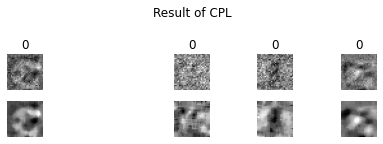

In [21]:
from matplotlib import pyplot as plt
import cv2

net.eval()
cpl_attacker = GradientInversion_Attack(net, (784,), lr=0.3, log_interval=50,
                                    optimizer_class=torch.optim.LBFGS,
                                    distancename="l2", optimize_label=False,
                                    num_iteration=200)

num_seeds=5
fig = plt.figure(figsize=(6, 2))
for s in tqdm(range(num_seeds)):
    cpl_attacker.reset_seed(s)
    try:
        result = cpl_attacker.attack(received_gradients)
        ax1 = fig.add_subplot(2, num_seeds, s+1)
        ax1.imshow(result[0].cpu().detach().numpy()[0].reshape(28, 28), cmap="gray")
        ax1.axis("off")
        ax1.set_title(torch.argmax(result[1]).cpu().item())
        ax2 = fig.add_subplot(2, num_seeds, num_seeds+s+1)
        ax2.imshow(cv2.medianBlur(result[0].cpu().detach().numpy()[0].reshape(28, 28), 5), cmap="gray")
        ax2.axis("off")
    except:
        pass
plt.suptitle("Result of CPL")
plt.tight_layout()
plt.show()